# Детектор номерных знаков

In [188]:
import os
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import keras.callbacks
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from yad2k.models.keras_yolo import (preprocess_true_boxes, yolo_body,
                                     yolo_eval, yolo_head, yolo_loss)
from yad2k.utils.draw_boxes import draw_boxes
import random as rd
import cv2

In [189]:
%matplotlib inline

Функция получения классов. В нашем случае будет всего один класс - Автомобильные номера

In [190]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

Функция загрузки Якорных ящиков (Anchors boxes)

In [191]:
def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)


Получение имени файла без папок и расширения (т.е. его id)

In [192]:
def get_ids(voc_path):
    """Get image identifiers for corresponding list of dataset identifies.
    Parameters
    ----------
    voc_path : str
        Path to VOCdevkit directory.
    datasets : list of str tuples
        List of dataset identifiers in the form of (year, dataset) pairs.
    Returns
    -------
    ids : list of str
        List of all image identifiers for given datasets.
    """
    ids = []
    files_images = glob.iglob(os.path.join(voc_path, "*.JPEG"))
    for x in files_images:
        name = os.path.splitext(os.path.basename(x))[0]
        ids.append(name)
#     print("names: ", ids)
    return ids

Функция получения координат боксов из файла

In [193]:
def get_boxes_for_id(voc_path, image_id):
    """Get object bounding boxes annotations for given image.
    Parameters
    ----------
    voc_path : str
        Path to VOCdevkit directory.
    image_id : str
        Pascal VOC identifier for given image.
    Returns
    -------
    boxes : array of int
        bounding box annotations of class label, xcenter, ycenter, box_width, box_height, image_width, image_height
        7xN array.
    """
    fname = os.path.join(voc_path, 'obj/{}.txt'.format(image_id))

    boxes = []
    with open(fname) as txt_file:
        for line in txt_file.readlines():
            if(len(line) < 1):
                continue
            try:
                elems = line.split(' ')
                bbox = [
                    float(elems[1]),
                    float(elems[2]),
                    float(elems[3]),
                    float(elems[4]),
                    int(elems[0]),
                ]
                boxes.append(bbox)
            except:
                "problem with get boxes from file: " + str(fname)    
           

    return np.array(boxes)

Функция определения масок

In [194]:
def get_detector_mask(boxes, anchors):
    '''
    Precompute detectors_mask and matching_true_boxes for training.
    Detectors mask is 1 for each spatial position in the final conv layer and
    anchor that should be active for the given boxes and 0 otherwise.
    Matching true boxes gives the regression targets for the ground truth box
    that caused a detector to be active or 0 otherwise.
    '''
    detectors_mask = [0 for i in range(len(boxes))]
    matching_true_boxes = [0 for i in range(len(boxes))]
    for i, box in enumerate(boxes):
        detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

    return np.array(detectors_mask), np.array(matching_true_boxes)

Загрузчик о аугментатор изображений и координат расположений

In [195]:
class TextImageGenerator(keras.callbacks.Callback):
    
    def __init__(self, images_dir, samples, batch_size, img_w, img_h, anchors, classes):
        self.images_dir = images_dir
        self.img_h = img_h
        self.img_w = img_w
        self.samples = samples
        self.batch_size = batch_size
        self.anchors = anchors
        self.classes = classes
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        rd.shuffle(self.indexes)
        self.cur_index = 0
        
    def aug(self, img, box):
        img_w = img.shape[1]
        img_h = img.shape[0]
        
        data_class = int(box[4])
        center_x_orig = box[0]   
        center_y_orig = box[1]   
        
        w_orig = box[2]   
        h_orig = box[3]   
        
        w = int(w_orig * img_w) // 2
        h = int(h_orig * img_h) // 2
        x1 = int(center_x_orig * img_w) -w
        y1 = int(center_y_orig * img_h) -h
        x2 = int(center_x_orig * img_w) +w
        y2 = int(center_y_orig * img_h) +h
        
        step = 60
        i = np.random.randint(0,10)
        offsetLeft = int(np.random.uniform(0, 1) * step * i)
        offsetRight = int(np.random.uniform(0, 1) * step * i)
        offsetTop = int(np.random.uniform(0, 1) * step * i)
        offsetBottom = int(np.random.uniform(0, 1) * step * i)
        offsetLeft, offsetRight, offsetTop, offsetBottom

        if y1 - offsetTop < 0:
            offsetTop = y1

        if y2 + offsetBottom >= img.shape[0]:
            offsetBottom = img.shape[0] - y2

        if x1 - offsetLeft < 0:
            offsetLeft = x1

        if y2 + offsetRight >= img.shape[1]:
            offsetRight = img.shape[1] - x2

#             print(offsetLeft, offsetRight, offsetTop, offsetBottom)

        crop_y1 = y1 - offsetTop
        crop_y2 = y2 + offsetBottom 
        crop_x1 = x1 - offsetLeft
        crop_x2 = x2+offsetRight

        img_croped = img[crop_y1: crop_y2 , crop_x1: crop_x2]
#             plt.imshow(img_croped)

        new_img_w = img_croped.shape[1]
        new_img_h = img_croped.shape[0]

        new_center_x_orig = 0.5 + (((offsetLeft - offsetRight)/2 )/ new_img_w) 
        new_center_y_orig = 0.5 + (((offsetTop - offsetBottom)/2)/ new_img_h) 

        new_w_orig = w_orig * (img_w / new_img_w)
        new_h_orig = h_orig * (img_h / new_img_h)
        
        return  img_croped, [new_center_x_orig, new_center_y_orig, new_w_orig, new_h_orig, data_class]
        
    def build_data(self, image_id):
        image_path = os.path.join(self.images_dir, 'obj/{}.JPEG'.format(image_id))
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        boxes = get_boxes_for_id(self.images_dir, image_id)
        
        if len(boxes) == 1:
            img, boxes[0] = self.aug(img, boxes[0])
        
        img_w = img.shape[1]
        img_h = img.shape[0]

        img = cv2.resize(img, (self.img_w, self.img_h))
        img = img.astype(np.float32)
        img /= 255
#         img = img.T.transpose(1,2,0)

        for i, box in enumerate(boxes):
            center_x_orig = box[0]   
            center_y_orig = box[1]   
            w_orig = box[2]   
            h_orig = box[3]   

            new_center_x_orig = center_x_orig
            new_center_y_orig = center_y_orig
            new_w_orig = w_orig * (self.img_w / img_w )
            new_h_orig = h_orig * (self.img_h / img_h )

            box[0] = new_center_x_orig
            box[1] = new_center_y_orig
            box[2] = new_w_orig
            box[3] = new_h_orig

       
        return img, boxes
        
    def get_output_size(self):
        return len(alphabet) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            rd.shuffle(self.indexes)
            
        return self.build_data(self.samples[self.indexes[self.cur_index]])
    
    def next_batch(self):
        while True:
            images = [] 
            boxes_list = []
            max_boxes = 0
            for i in range(self.batch_size):
                img, boxes = self.next_sample()
                if self.cur_index == 2 :
                    print("self.cur_index == 2")
                    plt.imshow(img)
                    
                images.append(img)
                boxes = boxes.reshape((-1, 5))
                boxes_list.append(boxes)
            
                if boxes.shape[0] > max_boxes:
                    max_boxes = boxes.shape[0]

                # add zero pad for training
            for i, boxes in enumerate(boxes_list):
                if boxes.shape[0]  < max_boxes:
                    zero_padding = np.zeros( (max_boxes-boxes.shape[0], 5), dtype=np.float32)
                    boxes_list[i] = np.vstack((boxes, zero_padding))
            
            image_data, boxes_list = np.array(images), np.array(boxes_list) 
            detectors_mask, matching_true_boxes = get_detector_mask(boxes_list, self.anchors)
            
            inputs = [image_data, boxes_list, detectors_mask, matching_true_boxes]
            outputs = {'yolo_loss': np.zeros([self.batch_size])}
            yield (inputs, outputs)
            

Функция создающая нашу модель

In [196]:
def create_model_tiny(anchors, class_names, load_pretrained=True, freeze_body=True):
    '''
    returns the body of the model and the model
    # Params:
    load_pretrained: whether or not to load the pretrained model or initialize all weights
    freeze_body: whether or not to freeze all weights except for the last layer's
    # Returns:
    model_body: YOLO with new output layer
    model: YOLO with custom loss Lambda layer

    '''

    detectors_mask_shape = (13, 13, 5, 1)
    matching_boxes_shape = (13, 13, 5, 5)

    # Create model input layers.
    image_input = Input(shape=(416, 416, 3), name="image_input")
    boxes_input = Input(shape=(None, 5), name="boxes_input")
    detectors_mask_input = Input(shape=detectors_mask_shape, name="detectors_mask_input")
    matching_boxes_input = Input(shape=matching_boxes_shape, name="matching_boxes_input")

    # Create model body.
    yolo_model = load_model(os.path.join('model_data', 'tiny_yolo.h5'))
    topless_yolo = Model(yolo_model.inputs , outputs=yolo_model.layers[-2].output)

    if load_pretrained:
        # Save topless yolo:
        topless_yolo_path = os.path.join('model_data', 'tiny_yolo_topless.h5')
        if not os.path.exists(topless_yolo_path):
            print("CREATING TOPLESS WEIGHTS FILE")
            yolo_path = os.path.join('model_data', 'tiny_yolo.h5')
            model_body = load_model(yolo_path)
            model_body = Model(model_body.inputs, outputs=model_body.layers[-2].output)
            model_body.save_weights(topless_yolo_path, overwrite=True)
        topless_yolo.load_weights(topless_yolo_path)

    if freeze_body:
        for layer in topless_yolo.layers:
            layer.trainable = False
    final_layer = Conv2D(len(anchors)*(5+len(class_names)), (1, 1), activation='linear', name="final_conv2d_layer")(topless_yolo.output)

    model_body = Model(yolo_model.inputs, final_layer)

    # Place model loss on CPU to reduce GPU memory usage.
    with tf.device('/cpu:0'):
        # TODO: Replace Lambda with custom Keras layer for loss.
        model_loss = Lambda(
            yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={'anchors': anchors,
                       'num_classes': len(class_names)})([
                           model_body.output, boxes_input,
                           detectors_mask_input, matching_boxes_input
                       ])

    model = Model(
        [model_body.input, boxes_input, detectors_mask_input,
         matching_boxes_input], model_loss)

    return model_body, model

Функция тренировки нашей модели

In [197]:
def train(model_name, model, class_names, anchors, images_dir, images_ids, val_split=0.2):
    '''
    retrain/fine-tune the model
    logs training with tensorboard
    saves training weights in current directory
    best weights according to val_loss is saved as trained_stage_3_best.h5
    
     image_data, boxes, detectors_mask, matching_true_boxes
    '''
    
    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

    minibatch_size = 32
    val_words = int(((len(images_ids)) * val_split) - \
                    (((len(images_ids)) * val_split) % minibatch_size))
    print("len train",len(images_ids))
    print("len val",val_words)
    
    logging = TensorBoard()
    
    img_gen = TextImageGenerator(images_dir, images_ids, minibatch_size, 416, 416, anchors, class_names)
    

    checkpoint = ModelCheckpoint("model_data/{}_trained_stage_3_best.h5".format(model_name), monitor='val_loss',
                                 save_weights_only=True, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

    
#     model.fit_generator(generator=img_gen.next_batch(),
#                     steps_per_epoch=img_gen.n // minibatch_size,
#                     epochs=5,
#                     validation_data=img_gen.next_batch(),
#                     validation_steps=val_words // minibatch_size,
#                     callbacks=[logging, img_gen])
    
    
#     model.save_weights('model_data/{}_trained_stage_1.h5'.format(model_name))

    model_body, model = create_model_tiny(anchors, class_names, load_pretrained=False, freeze_body=False)

    model.load_weights('model_data/{}_trained_stage_3_best.h5'.format(model_name))

    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.

#     model.fit_generator(generator=img_gen.next_batch(),
#                     steps_per_epoch=img_gen.n // minibatch_size,
#                     epochs=50,
#                     validation_data=img_gen.next_batch(),
#                     validation_steps=val_words // minibatch_size,
#                     callbacks=[logging, img_gen])


#     model.save_weights('model_data/{}_trained_stage_2.h5'.format(model_name))
    model.fit_generator(generator=img_gen.next_batch(),
                    steps_per_epoch=img_gen.n // minibatch_size,
                    epochs=50,
                    validation_data=img_gen.next_batch(),
                    validation_steps=val_words // minibatch_size,
                    callbacks=[logging, img_gen, checkpoint, early_stopping])
    
    model.save_weights('model_data/{}_trained_stage_3.h5'.format(model_name))

Определим параметры и загрузим изображения

In [198]:
model_name = "tiny"
voc_path = os.path.expanduser("in/data/")

anchors = get_anchors(os.path.join('in', 'yolo_anchors.txt'))
class_names = get_classes(os.path.join(voc_path, "obj.names"))
images_ids = get_ids(os.path.join(voc_path, "obj/"))


In [199]:
images_ids = images_ids + images_ids + images_ids

In [200]:
len(images_ids)

1332

In [201]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

/Users/vladimir/anaconda3/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


len train 1332
len val 256
Epoch 1/50
self.cur_index == 2
41/41 [==============================] - 378s - loss: 17.2184 - val_loss: 13.1595
Epoch 2/50
41/41 [==============================] - 371s - loss: 11.8436 - val_loss: 12.9956
Epoch 3/50
41/41 [==============================] - 373s - loss: 10.8107 - val_loss: 12.4085
Epoch 4/50
41/41 [==============================] - 373s - loss: 11.8589 - val_loss: 10.6499
Epoch 5/50
41/41 [==============================] - 374s - loss: 11.8590 - val_loss: 12.1452
Epoch 6/50
41/41 [==============================] - 373s - loss: 11.6322 - val_loss: 13.1243
Epoch 7/50
41/41 [==============================] - 375s - loss: 14.1267 - val_loss: 9.8952
Epoch 8/50
41/41 [==============================] - 374s - loss: 16.7478 - val_loss: 17.9291
Epoch 9/50
41/41 [==============================] - 373s - loss: 16.2769 - val_loss: 17.9819
Epoch 10/50
self.cur_index == 2
41/41 [==============================] - 374s - loss: 15.5095 - val_loss: 16.1541
Epo

KeyboardInterrupt: 

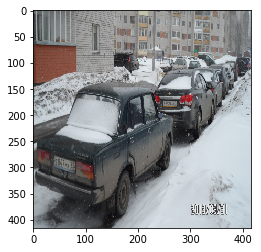

In [175]:
model_body, model = create_model_tiny(anchors, class_names)
#model_name, model, class_names, anchors, images_dir, images_ids, val_split=0.2
train(
    model_name,
    model,
    class_names,
    anchors,
    voc_path,
    images_ids
)

## Тестируем что получилось

Функция отрисовки результата

In [202]:
K.clear_session()
model_body, model = create_model_tiny(anchors, class_names)
model_body.load_weights('model_data/{}_trained_stage_3_best.h5'.format(model_name))

/Users/vladimir/anaconda3/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [203]:
def draw(model_body, class_names, anchors,images_dir, image_data, save_all=True):
#     '''
#     Draw bounding boxes on image data
#     '''
#     if image_set == 'train':
#         image_data = np.array([np.expand_dims(image, axis=0)
#             for image in image_data[:int(len(image_data)*.9)]])
#     elif image_set == 'val':
#         image_data = np.array([np.expand_dims(image, axis=0)
#             for image in image_data[int(len(image_data)*.9):]])
#     elif image_set == 'all':
#         image_data = np.array([np.expand_dims(image, axis=0)
#             for image in image_data])
#     else:
#         ValueError("draw argument image_set must be 'train', 'val', or 'all'")



    # Create output variables for prediction.
    yolo_outputs = yolo_head(model_body.output, anchors, len(class_names))
    input_image_shape = K.placeholder(shape=(2, ))
    boxes, scores, classes = yolo_eval(
        yolo_outputs, input_image_shape, score_threshold=0.07, iou_threshold=0.0)

    # Run prediction on overfit image.
    sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

#     if  not os.path.exists(out_path):
#         os.makedirs(out_path)
    for i in range(len(image_data)):
        image_path = os.path.join(images_dir, 'obj/{}.JPEG'.format(image_data[i]))
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #[200:500, 200:500]
        img = cv2.resize(img, (416,416))
        img = img/255
        
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model_body.input: [img],
                input_image_shape: [img.shape[0], img.shape[1]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for image.'.format(len(out_boxes)))
        print(out_boxes)

        # Plot image with predicted boxes.
        image_with_boxes = draw_boxes(img, out_boxes, out_classes,
                                    class_names, out_scores)
        # Save the image:
#         if save_all or (len(out_boxes) > 0):
#             image = PIL.Image.fromarray(image_with_boxes)
#             image.save(os.path.join(out_path,str(i)+'.png'))

        # To display (pauses the program):
        plt.imshow(image_with_boxes, interpolation='nearest')
        plt.show()

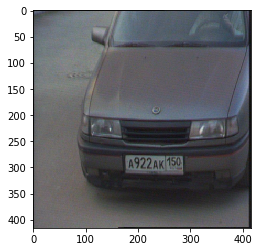

In [204]:
image_path = os.path.join(voc_path, 'obj/{}.JPEG'.format("image_0002"))
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (416,416))
plt.imshow(img)

Found 1 boxes for image.
[[ 209.00784302  184.44590759  230.02046204  241.43838501]]
car_num 0.78 (184, 209) (241, 230)


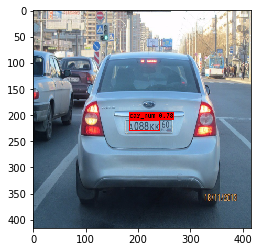

Found 1 boxes for image.
[[ 233.41790771  147.11032104  257.69277954  189.14450073]]
car_num 0.65 (147, 233) (189, 258)


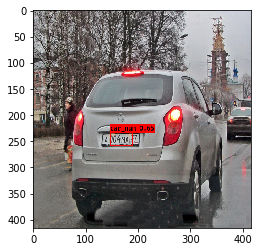

Found 1 boxes for image.
[[ 268.54916382  190.95245361  312.13262939  274.02462769]]
car_num 1.00 (191, 269) (274, 312)


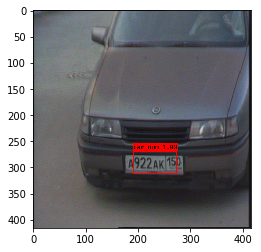

Found 1 boxes for image.
[[ 115.17228699  182.2219696   142.55192566  238.99273682]]
car_num 0.91 (182, 115) (239, 143)


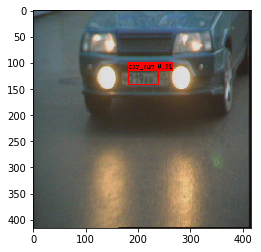

Found 1 boxes for image.
[[ 265.76934814  216.83729553  301.77374268  272.60836792]]
car_num 0.99 (217, 266) (273, 302)


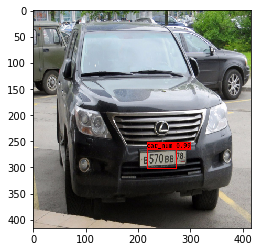

Found 1 boxes for image.
[[ 278.15274048  242.50610352  303.87704468  269.77246094]]
car_num 0.54 (243, 278) (270, 304)


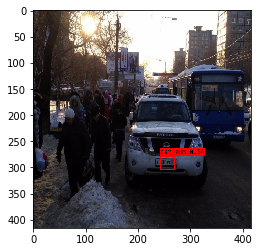

Found 1 boxes for image.
[[ 169.22232056  124.00656128  223.60115051  224.28204346]]
car_num 1.00 (124, 169) (224, 224)


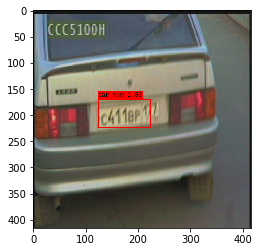

Found 1 boxes for image.
[[ 258.71990967  115.80402374  298.72174072  160.48634338]]
car_num 0.99 (116, 259) (160, 299)


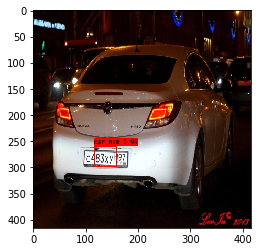

Found 1 boxes for image.
[[ 304.41360474   63.93609238  344.48895264  138.73445129]]
car_num 1.00 (64, 304) (139, 344)


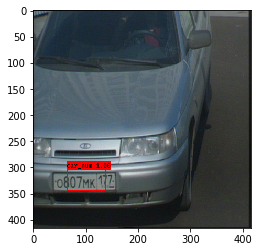

Found 1 boxes for image.
[[ 114.45321655  167.54492188  149.36157227  229.95306396]]
car_num 0.92 (168, 114) (230, 149)


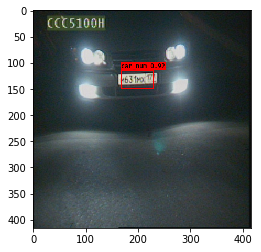

Found 1 boxes for image.
[[ 311.9152832   160.56704712  358.54669189  230.69230652]]
car_num 0.99 (161, 312) (231, 359)


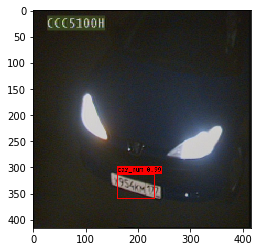

Found 1 boxes for image.
[[ 247.25370789  175.35125732  275.37734985  232.83909607]]
car_num 0.99 (175, 247) (233, 275)


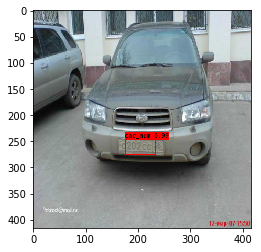

Found 1 boxes for image.
[[ 177.20509338  274.96560669  205.92729187  345.98739624]]
car_num 0.98 (275, 177) (346, 206)


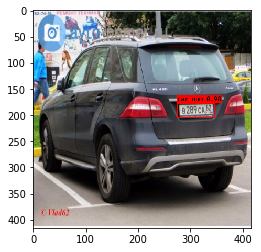

Found 1 boxes for image.
[[ 298.97991943  169.61755371  357.1270752   241.93908691]]
car_num 0.97 (170, 299) (242, 357)


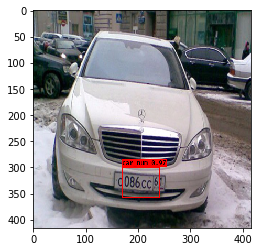

Found 1 boxes for image.
[[ 289.2204895   256.73077393  324.60821533  291.2618103 ]]
car_num 1.00 (257, 289) (291, 325)


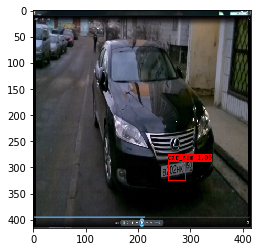

Found 1 boxes for image.
[[ 211.79760742  231.31541443  259.82769775  314.1204834 ]]
car_num 0.93 (231, 212) (314, 260)


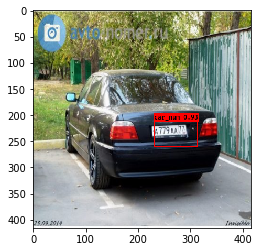

Found 1 boxes for image.
[[ 223.30462646  148.06452942  256.45370483  204.28053284]]
car_num 0.99 (148, 223) (204, 256)


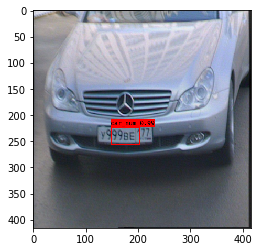

Found 1 boxes for image.
[[ 203.98823547  157.40104675  240.35906982  239.69035339]]
car_num 1.00 (157, 204) (240, 240)


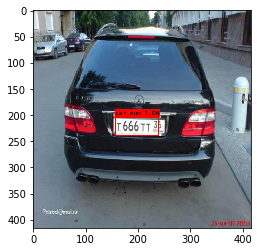

Found 1 boxes for image.
[[ 259.32070923  304.72497559  293.44064331  357.05065918]]
car_num 1.00 (305, 259) (357, 293)


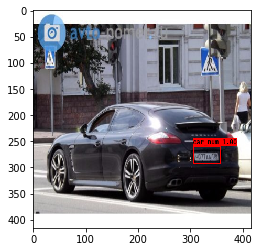

Found 1 boxes for image.
[[ 221.44985962  274.39880371  253.60247803  334.85647583]]
car_num 0.99 (274, 221) (335, 254)


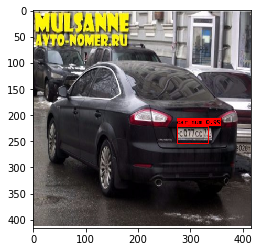

In [205]:
draw(model_body,
    class_names,
    anchors,
    voc_path,
    images_ids[0:20],
    save_all=True)

Сохраним модель с весами

In [180]:
model_body.save(os.path.join('model_data', '{}_yolo_finish.h5'.format(model_name)))

## Функция для выгрузки в Андроид

In [181]:
def save_to_android(input_name, output_name, model_name, weights_name):
    K.set_learning_phase(0)

    model = load_model(os.path.join('model_data', model_name), compile=False)
    model.load_weights(os.path.join('model_data', weights_name))

    sess = K.get_session()

    export_base_path = 'tf-exports'
    if not os.path.exists(export_base_path):
        os.makedirs(export_base_path)
    
    protobuf_path = os.path.join(export_base_path, 'yolo-tiny-v1.pbtxt')
    checkpoint_path = os.path.join(export_base_path, 'yolo-tiny-v1.ckpt')

    tf.train.write_graph(sess.graph_def, '.', protobuf_path)

    saver = tf.train.Saver()
    saver.save(sess, save_path = checkpoint_path)

Сохраним данные о модели в protobuf для последующей выгрузки в Андроид

In [182]:
K.clear_session()
input_name = 'input_1' 
output_name = 'final_conv2d_layer/BiasAdd' 
save_to_android(input_name, 
                output_name,
                model_name='{}_yolo_finish.h5'.format(model_name), 
                weights_name='{}_trained_stage_3_best.h5'.format(model_name))

## Функция нарезающая номерные знаки, пригодится для подготовки данных для распознания

In [ ]:
def crop_and_resize(index, image, boxes, box_classes, croped_output_path):
    image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))

    for i, c in list(enumerate(box_classes)):
        box = boxes[i]

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print("croped and resized:",os.path.join(croped_output_path, str(index) + '.png'))

        image_crop = image.crop([left + i, top + i, right - i, bottom - i])
        image_resize = image_crop.resize((416,416), resample=Image.BICUBIC)
        image_resize.save(os.path.join(croped_output_path, str(index) + '.png'))
        

In [ ]:
def crop_and_save_numbers_licence(model, class_names, anchors, image_data, output_path="output_images", save_all=True, croped_output_path=None):
    '''
    Draw bounding boxes on image data
    '''
    image_data = np.array([np.expand_dims(image, axis=0)
                           for image in image_data])
    print("model.output", model.output)
    # Tensor("yolo_loss/mul_13:0", shape=(), dtype=float32, device=/device:CPU:0)
    # Create output variables for prediction.
    yolo_outputs = yolo_head(model.output, anchors, len(class_names))
    input_image_shape = K.placeholder(shape=(2, ))
    boxes, scores, classes = yolo_eval(
        yolo_outputs, input_image_shape, score_threshold=0.07, iou_threshold=0.0)

    # Run prediction on overfit image.
    sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

    if not os.path.exists(output_path):
        os.makedirs(output_path)
    for i in range(len(image_data)):
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model.input: image_data[i],
                input_image_shape: [image_data.shape[2], image_data.shape[3]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for image.'.format(len(out_boxes)))
        print(out_boxes)
        print("croped_output_path:",croped_output_path)

        # Plot image with predicted boxes.
        image_with_boxes = draw_boxes(image_data[i][0], out_boxes, out_classes,
                                      class_names, out_scores)
        # Save the image:
        if save_all or (len(out_boxes) > 0):
            image = Image.fromarray(image_with_boxes)
            image.save(os.path.join(output_path, str(i) + '.png'))

        if croped_output_path != None :
            crop_and_resize(i, image_data[i][0], out_boxes, out_classes, croped_output_path)
        # To display (pauses the program):
        # plt.imshow(image_with_boxes, interpolation='nearest')
        # plt.show()